In [ ]:
#%pip install git+https://github.com/gbdrt/mu-ppl

In [1]:
from mu_ppl import *
import numpy as np
import matplotlib.pyplot as plt

# Bayesian Reasoning

In a nutshell, Bayesian resonning computes the _posterior_ distribution of a random variable from a _prior_ distribution and _observed_ data.

## The coin example 

The "hello world" example for Bayesian reasoning estimates the bias of a coin from a series of observations.
The random variable of interest `z` corresponds to the bias to the coin: `z=0.5` is a fair coin, `z = 0` is a coin which always falls tail.
We want to compute a distribution of possible values for `z` given a series of observed coin flips.

For instance the result of 10 coin flip could be the following:

In [2]:
flips = [0, 1, 0, 0, 0, 0, 1, 0, 0, 0]


Initially, we have no information, `z` could be anything in between $0$ and $1$: the _prior_ distribution is the uniform distribution over $[0, 1]$.
But we do know that each coin flip `y_i` follows a Bernoulli distribution parameterized by `z`.
Our goal is to estimate $P(z | y_1, y_2, ... y_n)$.

### Generative model

This exercise can be directly translated into the following mu-PPL program, or _generative model_.

In [3]:
def coin(flips: list[int]) -> float:
    z = sample(Uniform(0, 1))
    for yi in flips:
        observe(Bernoulli(z), yi)
    return z

The `observe(d, v)` statement is a shortcut for `factor(d.log_prob(v))` which conditions the current execution on the _likelihood_ of the value `v` w.r.t. the distribution `d`.
In other words, when we write `observe(d, v)` we make the assumption that `v` was sampled from the distribution `d`.

### Inference

In our example, the domain of the random variable `z` is the entire interval $[0, 1]$. Enumeration of all possible execution is not possible.
But, we can use approximate inference scheme to compute the posterior distribution.

mu-PPL offers several approximate inference algorithms, ranging from basic importance sampling to Markov Chain Monte Carlo (MCMC), and sequential Monte Carlo (SMC).

For instance, we can try importance sampling to approximate the posterior distribution of our model with 1000 samples.

100%|██████████| 10000/10000 [00:02<00:00, 3955.64it/s]


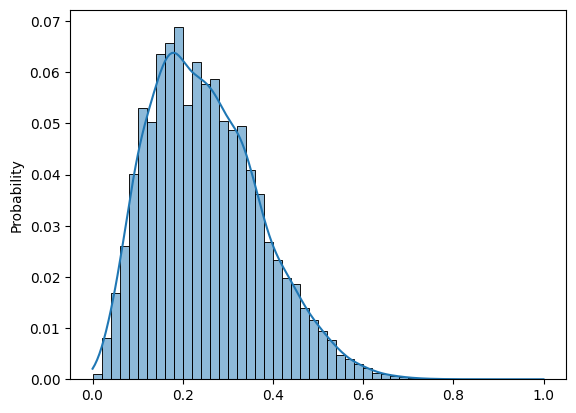

In [4]:
with ImportanceSampling(num_particles=10000):
    dist: Categorical[float] = infer(coin, flips)  # type: ignore
    viz(dist)

On this simple example, we get a result that is very close to the exact solution: a Beta distribution with parameter `#tail + 1` and `#head + 1`.

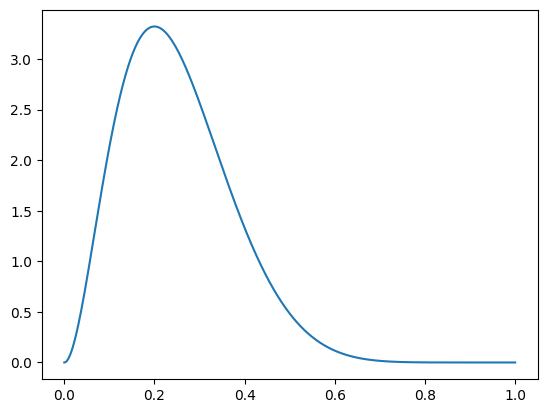

In [5]:
from scipy.stats import beta

x = np.linspace(0, 1, 1000)
f = np.array(flips)
y = beta.pdf(x, np.sum(f) + 1, np.sum(1 - f) + 1)
plt.plot(x, y)

## Linear regression

The goal of this exercise is to find a linear regression, but rather than finding the best solution, we're looking for a distribution of possible regressions.

Consider the following noisy data.

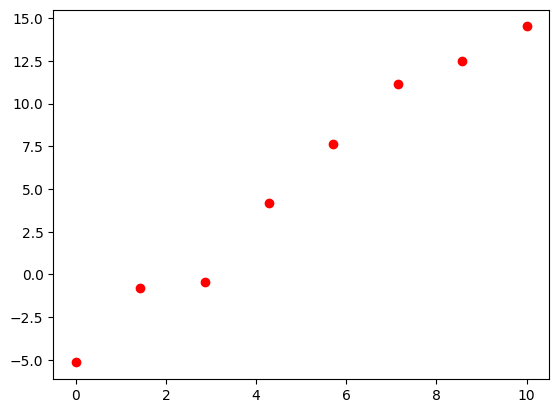

In [20]:
N = 8
noise = 1
lower = 0
upper = 10

x_obs = np.linspace(lower, upper, N)
y_obs = 2 * x_obs - 4  + noise * np.random.randn(N)

plt.scatter(x_obs, y_obs, color='red')

Propose a first linear regression model $y \sim \mathcal{N}(ax + b, \sigma)$.  
We want to estimate the parameters $a$, $b$, and $\sigma$ (noise).

In [21]:
def model(x_obs, y_obs):
    a = sample(Gaussian(0, 5), name="a")
    b = sample(Gaussian(0, 5), name="b")
    sigma = sample(Uniform(0, 2), name="sigma")
    for (xo, yo) in zip(x_obs, y_obs):
        observe(Gaussian(a*xo + b, sigma), yo)
    return [a, b, sigma]

In [23]:
with ImportanceSampling(num_particles=10000):
    dist: Empirical[list[float]] = infer(model, x_obs, y_obs)  # type: ignore
    coefs_dists = split(dist)
    [a_dist, b_dist, sigma_dist] = coefs_dists
    [a, b, sigma] = map(lambda d: d.stats()[0], coefs_dists)

100%|██████████| 10000/10000 [00:01<00:00, 5568.19it/s]


We can now display some samples to check the posterior distribution.

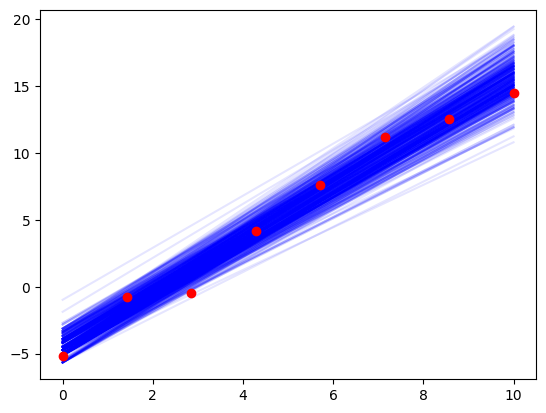

In [24]:
for i in range(500):
    x = np.linspace(lower, upper, 2)
    a = a_dist.sample()
    b = b_dist.sample()
    plt.plot(x, a * x + b, color='blue', alpha=0.1, zorder=0)
    
plt.scatter(x_obs, y_obs, color='red', zorder=1)